# Homework week08

In [1]:
import torch

from transformers import AutoTokenizer, AutoModelForCausalLM

## Task 1 [Speculative Sampling][4 points]

Algorithm for accelerating transformer decoding by enabling the generation of multiple tokens from each transformer call. Our algorithm relies on the observation that the latency of parallel scoring of short continuations, generated by a faster but less powerful draft model, is comparable to that of sampling a single token from the larger target model.


Carefully read https://arxiv.org/abs/2302.01318

### Autoregressive Sampling

<img width="654" alt="image" src="https://github.com/markovka17/dla/assets/20357655/db624e40-d4f0-4e36-88e7-b58a6c646738">

Let's take `EleutherAI/gpt-neo-1.3B` LM as a draft model from https://huggingface.co and generate a couple dozen tokens.

In [2]:
# Ensure that your device is set correctly (GPU or CPU)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load pre-trained model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-j-6B")
model = AutoModelForCausalLM.from_pretrained('EleutherAI/gpt-neo-1.3B', torch_dtype=torch.float32).to(device)
model.eval()  # Set the model to evaluation mode

# Prepare a text prompt
text_prompt = ["The quick brown fox jumps"]
inputs = tokenizer(text_prompt, return_tensors='pt').to(device)  # Tokenize the text prompt and convert to tensor

# Perform text generation (inference)
# Note: manual handling means we will manage the generated text and stop criteria without using generate() method
max_length = 100  # Maximum length of the generated text
temperature = 1.0  # Sampling temperature, higher values mean more randomness

with torch.no_grad():  # Disable gradient calculation for inference
    output_sequence = inputs['input_ids']
    for _ in range(max_length - inputs['input_ids'].size(1)):
        # Predict the next token
        logits = model(output_sequence).logits[:, -1, :]
        
        # Apply temperature
        logits = logits / temperature
        
        # Sample the next token from the probability distribution
        probabilities = torch.nn.functional.softmax(logits, dim=-1)
        next_token = torch.multinomial(probabilities, num_samples=1)
        
        # Append the predicted token to the output sequence
        output_sequence = torch.cat([output_sequence, next_token], dim=1)

        # Check if the end-of-sequence token (EOS) was generated
        if next_token.item() == tokenizer.eos_token_id:
            break

# Decode and print the generated text
generated_text = tokenizer.decode(output_sequence.squeeze(), skip_special_tokens=True)
print("Generated text:\n", generated_text)


Generated text:
 The quick brown fox jumps over the lazy dog... it always has, even when it tried too.

—The Swing Department by Stephen Crane

The Ethics of Investor Relations in Crowdfunding



People can back the crunch offbx with all that they've got—not even perverted religion yet. They should have the screen magnifying glasses of Hitachi Capital in the bite marks on the neck of the black cash cow who put their Beautiful Gestation of facebook's Facebook


### Task 1.1

Ans let's use `EleutherAI/gpt-j-6B` as target model.

In [3]:
# large_model = AutoModelForCausalLM.from_pretrained("EleutherAI/gpt-j-6B", torch_dtype=torch.float32).to(device)
# large_model.eval()

In speculative sampling, we have two models:

    A smaller, faster draft model (e.g. EleutherAI/gpt-neo-1.3B model)
    A larger, slower target model (e.g. EleutherAI/gpt-j-6B model)

The idea is that the draft model speculates what the output is steps into the future, while the target model determines how many of those tokens we should accept. Here's an outline of the algorithm:

The draft model decodes tokens in the regular autoregressive fashion.
We get the probability outputs of the target and draft model on the new predicted sequence.
We compare the target and draft model probabilities to determine how many of the tokens we want to keep based on some rejection criteria. If a token is rejected, we resample it using a combination of the two distributions and don't accept any more tokens.
If all tokens are accepted, we can sample an additional final token from the target model probability output.

<img width="635" alt="image" src="https://github.com/markovka17/dla/assets/20357655/3954894d-8735-4f92-a835-d04eac74f190">

In [186]:
def sample_new_token(model, tokens, temp: float = 1.0):
    '''Sample new token given model and prompt. '''
    logits = model(tokens).logits[:, -1, :] / temp 
    probas = torch.nn.functional.softmax(logits, dim=-1)
    new_token = torch.multinomial(probas, num_samples=1)
    return new_token, logits


def build_parallel_batch(old_tokens, new_tokens):
    '''Build batch by concatenating old and new tokens. '''
    k = new_tokens.size(1)
    tokens = torch.cat([old_tokens.tile(k, 1), torch.tril(new_tokens.tile(k, 1))], dim=1)
    return tokens, (tokens != 0) * 1.0


def get_target_logits(target_model, old_tokens, new_tokens, temp: float = 1.0):
    '''Obtain target logits in parallel from target model. '''
    tokens_batch, attn_masks = build_parallel_batch(old_tokens, new_tokens)
    idxs = torch.arange(old_tokens.size(1), old_tokens.size(1) + new_tokens.size(1)) - 1
    logits = target_model(
        input_ids=tokens_batch, attention_mask=attn_masks
    ).logits[torch.arange(tokens_batch.size(0)), idxs, :] / temp
    return logits   


def simulate_with_draft(draft_model, x_draft, K):
    '''Simulate K draft tokens from the draft model. '''
    new_tokens, draft_logits = [], []
    for _ in range(K):
        new_token, new_token_proba = sample_new_token(draft_model, x_draft)
        x_draft = torch.cat([x_draft, new_token], dim=1)
        
        new_tokens.append(new_token)
        draft_logits.append(new_token_proba)

    return torch.cat(new_tokens, dim=1), torch.cat(draft_logits, dim=0)


def run_rejection_sampling(target_logits, draft_logits, draft_tokens, x, K, EOS=tokenizer.eos_token_id):
    '''Run rejection sampling given target and draft logits. '''
    n_accepted = 0
    all_accepted = True
    is_eos = False
    
    for idx in range(K):        
        next_token = draft_tokens[:, idx]

        q = torch.nn.functional.softmax(target_logits[idx], dim=-1)[next_token]
        p = torch.nn.functional.softmax(draft_logits[idx], dim=-1)[next_token]
        
        if torch.rand(1) < torch.minimum(torch.ones(1), q / p):
            n_accepted += 1
        else:
            all_accepted = False
            
            fall_back_logits = torch.nn.functional.relu(target_logits[idx] - draft_logits[idx])
            fall_back_proba = torch.nn.functional.softmax(fall_back_logits, dim=-1)
            next_token = torch.multinomial(fall_back_proba, num_samples=1)

        if next_token.item() == EOS:
            is_eos = True
            break
    
        x = torch.cat([x, next_token.reshape(1, -1)], dim=1)
        if not all_accepted:
            break

    acc_ration = 1.0 if is_eos and all_accepted else n_accepted / K
    return x, all_accepted, is_eos, acc_ration

In [189]:
# The backbone of the speculative sample. Feel free to modify it
@torch.no_grad()
def speculative_sampling(x, draft_model, target_model, N, K):
    # NOTE: paper indexes arrays starting from 1, python indexes from 0, so
    # we have to add an extra -1 term when indexing using n, T, or t
    n = len(x)
    acceptance_ratios = []

    for _ in range(N):
        # Step 1: auto-regressive decode K tokens from draft model and get final p
        x_draft = x
        draft_tokens, draft_logits = simulate_with_draft(draft_model, x_draft, K)        
        
        # Step 2: target model forward passes on x_draft
        target_logits = get_target_logits(target_model, x, draft_tokens)
        assert draft_logits.size(0) == target_logits.size(0) == K, "Eto posos"
        
        # Step 3: append draft tokens based on rejection criterion and resample a token on rejection
        x, all_accepted, is_eos, acc_ratio = run_rejection_sampling(
            target_logits, draft_logits, draft_tokens, x, K
        )
        acceptance_ratios.append(acc_ratio)
        if is_eos or x.size(1) >= N:
            break

        # Step 4: if all draft tokens were accepted, sample a final token
        if all_accepted:
            next_token, _ = sample_new_token(target_model, x)
            
            if next_token.item() == tokenizer.eos_token_id:
                break
            
            x = torch.cat([x, next_token], dim=1)

        if x.size(1) >= N:
            break

    return x, acceptance_ratios

### Toy example for quality check

In [190]:
draft_model = model
target_model = model
x = inputs['input_ids']

N = 16
K = 4

In [196]:
x, acc_ratio = speculative_sampling(x, draft_model, target_model, N, K)

### Task 1.2,

Compare the speed of SpS with ArS. The expected speed increase is 30-50%. 
The speedup is equal to `(time spent by ArS)` / `(time spend by SpS)`

Use same start prompt `The quick brown fox jumps`, `K=16` and `K=32` (compare two scenarios) and `max_length=512`

In [ ]:
from time import time

In [ ]:
N , K = 512, 16
start = time()
*_ = speculative_sampling(x, draft_model, target_model, N, K)
print(f"Time taken: {time() - start:.3f}s")

In [ ]:
N , K = 512, 32
start = time()
*_ = speculative_sampling(x, draft_model, target_model, N, K)
print(f"Time taken: {time() - start:.3f}s")

### Task 1.3

Visualise acceptence rate for `K=[16, 32, 64, 128]`, same start prompt and `max_length max_length=1024`, where graft model is `EleutherAI/gpt-neo-1.3B` and target model if `EleutherAI/gpt-j-6B`.

In [199]:
import matplotlib.pyplot as plt

In [200]:
N = 20
rates = []

# for K in [16, 32, 64, 128]:
for K in [2, 4, 8]:
    x = inputs['input_ids']
    _, acc_rate = speculative_sampling(x, draft_model, target_model, N, K)
    rates.append(acc_rate)

5
3
2


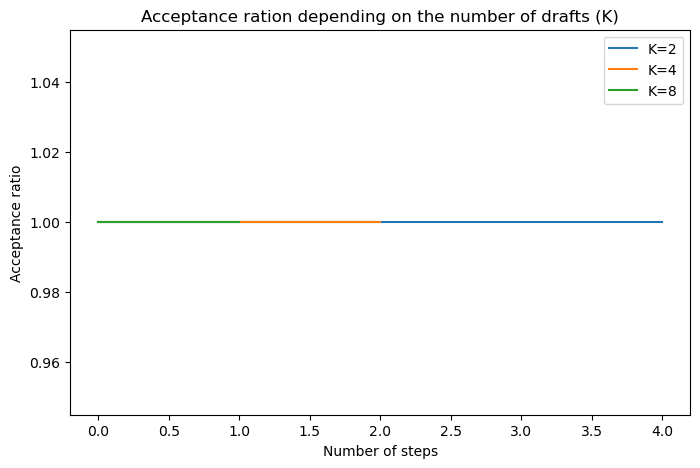

In [213]:
plt.figure(figsize=(8, 5))
for rate, K in zip(rates, [2, 4, 8]):
    print(len(rate))
    plt.plot(rate, label=f"{K=}")

plt.title("Acceptance ration depending on the number of drafts (K)")
plt.xlabel("Number of steps")
plt.ylabel("Acceptance ratio")
plt.legend()
plt.show()

## Task 2 [GroupNorm in Triton][6 points]


You need to implement a 2D GroupNorm (https://pytorch.org/docs/stable/generated/torch.nn.GroupNorm.html) and compare it to the PyTorch implementation.
Note that GroupNorm is very similar to LayerNorm, so you can see the LayerNorm implementation here https://triton-lang.org/main/getting-started/tutorials/05-layer-norm.html#.

In [214]:
# import triton
# import triton.language as tl

In [ ]:
@triton.jit
def _group_norm_fwd_fused(
    X,  # pointer to the input
    Y,  # pointer to the output
    W,  # pointer to the weights
    B,  # pointer to the biases
    Mean,  # pointer to the mean
    Rstd,  # pointer to the 1/std
    stride,  # how much to increase the pointer when moving by 1 row
    N,  # number of columns in X
    num_groups,  # number of groups
    eps,  # epsilon to avoid division by zero
    BLOCK_SIZE: tl.constexpr,  # Same parameters as in matmul from seminar
):
    """
    Similar to forward of nn.GroupNorm.forward
    """
    
    pass

In [ ]:
@triton.jit
def _group_norm_bwd_dx_fused(
    DX,  # pointer to the input gradient
    DY,  # pointer to the output gradient
    DW,  # pointer to the partial sum of weights gradient
    DB,  # pointer to the partial sum of biases gradient
    X,  # pointer to the input
    W,  # pointer to the weights
    B,  # pointer to the biases
    Mean,  # pointer to the mean
    Rstd,  # pointer to the 1/std
    stride,  # how much to increase the pointer when moving by 1 row
    N,  # number of columns in X
    eps,  # epsilon to avoid division by zero
    GROUP_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr  # Same parameters as in matmul from seminar
):
    """
    Backward of GroupNorm respect to input
    """
    pass

In [ ]:
@triton.jit
def _group_norm_bwd_dwdb(
    DW,  # pointer to the partial sum of weights gradient
    DB,  # pointer to the partial sum of biases gradient
    FINAL_DW,  # pointer to the weights gradient
    FINAL_DB,  # pointer to the biases gradient
    M,  # GROUP_SIZE_M
    N,  # number of columns
    BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr  # Same parameters as in matmul from seminar
):
    """
    Backward of GroupNorm respect to weights and biases (affine transform parameters)
    """
    pass

In [ ]:
class GroupNorm(torch.autograd.Function):

    @staticmethod
    def forward(ctx, x, num_groups, weight, bias, eps):
        assert x.size(2) % num_groups == 0, "channel dim is not divisible by num_groups"

        B, C, H, W = x.shape
        x = x.reshape(B, num_groups, C // num_groups, H, W)
        x = x.reshape(B, num_groups, C // num_groups * H, W)
        x = x.countiguos()

    @staticmethod
    def backward(ctx):
        pass

group_norm = GroupNorm.apply

In [8]:
x = torch.randn(1, 32, 64, 64)
num_groups = 8
eps=1e-9
weight = torch.rand(32, requires_grad=True)
bias = torch.rand(32, requires_grad=True)

true_out = torch.nn.functional.group_norm(x, num_groups, weight, bias, eps)

In [32]:
def false_group_norm(x, num_groups, weight, bias, eps):
    B, C, H, W = x.shape
    x = x.reshape(B, num_groups, C // num_groups, H, W)
    x = x.reshape(B * num_groups, C // num_groups * H * W)
    # # x = x.contiguos()
    # mean = x.mean(dim=-1, keepdims=True)
    # var = x.var(dim=-1, keepdims=True)

    # y = (x - mean) / (var + eps).sqrt()
    y = torch.nn.functional.layer_norm(x, [C // num_groups * H * W], weight, bias, eps)
    
    y = y.reshape(B,  num_groups, C // num_groups,  H,  W)
    y = y.reshape(B,  C,  H,  W)
    return y * weight.reshape(1, -1, 1, 1) + bias.reshape(1, -1, 1, 1)

In [33]:
torch.allclose(false_group_norm(x, num_groups, weight, bias, eps), true_out, atol=1e-2, rtol=0)

RuntimeError: Expected weight to be of same shape as normalized_shape, but got weight of shape [32] and normalized_shape = [16384]

In [27]:
torch.abs(false_group_norm(x, num_groups, weight, bias, eps) - true_out).max()

tensor(0.0001, grad_fn=<MaxBackward1>)

### Testing

In [ ]:
def test_group_norm(input_shape, num_groups, dtype, eps=1e-5, device='cuda'):
    # create data
    B, C, H, W = input_shape
    weight = torch.rand(C, dtype=dtype, device='cuda', requires_grad=True)
    bias = torch.rand(C, dtype=dtype, device='cuda', requires_grad=True)
    x = -2.3 + 0.5 * torch.randn(input_shape, dtype=dtype, device='cuda')
    dy = .1 * torch.randn_like(x)

    x.requires_grad_(True)
    # forward pass
    y_tri = group_norm(x, num_groups, weight, bias, eps)
    y_ref = torch.nn.functional.group_norm(x, num_groups, weight, bias, eps).to(dtype)
    # backward pass (triton)
    y_tri.backward(dy, retain_graph=True)
    dx_tri, dw_tri, db_tri = [_.grad.clone() for _ in [x, weight, bias]]
    x.grad, weight.grad, bias.grad = None, None, None
    # backward pass (torch)
    y_ref.backward(dy, retain_graph=True)
    dx_ref, dw_ref, db_ref = [_.grad.clone() for _ in [x, weight, bias]]
    # compare
    assert torch.allclose(y_tri, y_ref, atol=1e-2, rtol=0)
    assert torch.allclose(dx_tri, dx_ref, atol=1e-2, rtol=0)
    assert torch.allclose(db_tri, db_ref, atol=1e-2, rtol=0)
    assert torch.allclose(dw_tri, dw_ref, atol=1e-2, rtol=0)

In [ ]:
input_shape = (1, 32, 64, 64)
num_groups = 8
test_group_norm(input_shape, num_groups, torch.float16)

### Task 2.1

Visualize perfomance benchmark using `triton.testing.perf_report`. Similar to matmul benchmark from seminar

In [ ]:
# You need to check your implementation for the following parameters
batch_size = 2
for image_resolution in [32, 128, 512, 1024, 1536, 2048]:
    for num_channels in [32, 128, 386, 512]:
        for num_groups in [1, 4, 8, 16, 32]:

            dummy_input = torch.randn(batch_size, num_channels, image_resolution, image_resolution)

            # TODO benchmark